<a href="https://colab.research.google.com/github/MECAI2022/short_text_classification/blob/main/Short_Text_Bert_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Sort Text com BERT

In [ ]:
!nvidia-smi

Fri Dec  9 02:06:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    30W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## O Que é BERT?

BERT (introduzido [neste artigo](https://arxiv.org/abs/1810.04805)) significa  Bidirectional Encoder Representations from Transformers:

- Bidirecional - Para entender o texto que você está analisando, você terá que olhar para trás (nas palavras anteriores) e para frente (nas próximas palavras)
- Transformers - O artigo [Attention Is All You Need](https://arxiv.org/abs/1706.03762) apresentou o modelo Transformer. O Transformer lê sequências inteiras de tokens de uma só vez. Em certo sentido, o modelo é não direcional, enquanto os LSTMs lêem sequencialmente (da esquerda para a direita ou da direita para a esquerda). O mecanismo de atenção permite aprender relações contextuais entre palavras.
- Embeddings de palavras contextualizadas (pré-treinadas) - [The ELMO paper](https://arxiv.org/abs/1802.05365v2) introduziu uma maneira de codificar palavras com base em seu significado/contexto.

O BERT foi treinado mascarando 15% dos tokens com o objetivo de adivinhá-los. Um objetivo adicional era prever a próxima frase. Vejamos exemplos dessas tarefas:

### Modelagem de linguagem mascarada (LM mascarado)

O objetivo desta tarefa é adivinhar os tokens mascarados. Vamos dar uma olhada em um exemplo, e tentar não torná-lo mais difícil do que tem que ser:

Isso é `[máscara]` ela `[máscara]` -> Isso é o que ela disse

### Previsão da próxima frase (NSP)

Dado um par de duas sentenças, a tarefa é dizer se a segunda segue ou não a primeira (classificação binária). Vamos continuar com o exemplo:

*Input* = `[CLS]` Isso é `[mask]` ela `[mask]`. [SEP] Hahaha, legal! [SEP]

*Rótulo* = *ÉPróximo*

*Input* = `[CLS]` Isso é `[mask]` ela `[mask]`. [SEP] Dwight, seu ignorante `[máscara]`! [SEP]

*Rótulo* = *NãoPróximo*

O corpus de treinamento foi composto por duas entradas: [Toronto Book Corpus](https://arxiv.org/abs/1506.06724) (800 milhões de palavras) e Wikipedia em inglês (2.500 milhões de palavras). Enquanto o Transformer original possui um codificador (para leitura da entrada) e um decodificador (que faz a previsão), o BERT utiliza apenas o decodificador.

BERT é simplesmente vários  pré-treinada de codificadores de transformadores. Quantos codificadores? Temos duas versões - com 12 (BERT base) e 24 (BERT Large).

### Isso é útil na prática?

O artigo BERT foi lançado junto com [o código-fonte](https://github.com/google-research/bert) e modelos pré-treinados.

A melhor parte é que você pode fazer o Transfer Learning (graças às ideias do OpenAI Transformer) com BERT para muitas tarefas de NLP - Classificação, Resposta a Perguntas, Reconhecimento de Entidades, etc. Você pode treinar com pequenas quantidades de dados e obter um ótimo desempenho!

#### Setup & Config

Vamos precisar da [biblioteca Transformers](https://huggingface.co/transformers/) do Hugging Face:

In [ ]:
!git clone https://github.com/MECAI2022/short_text_classification.git
import sys
sys.path.append('/content/short_text_classification')
from pre_treatment_product import pre_process_text

Cloning into 'short_text_classification'...
remote: Enumerating objects: 116, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 116 (delta 0), reused 0 (delta 0), pack-reused 112
Receiving objects: 100% (116/116), 3.30 MiB | 29.38 MiB/s, done.
Resolving deltas: 100% (62/62), done.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
!pip install transformers
!pip install nlpaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 27.8 MB/s 
     |████████████████████████████████| 182 kB 75.5 MB/s 
     |████████████████████████████████| 7.6 MB 67.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 410 kB 30.5 MB/s 


In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup,get_cosine_with_hard_restarts_schedule_with_warmup
import torch

import os
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score,roc_auc_score
from collections import defaultdict
from textwrap import wrap
from sklearn import preprocessing
import itertools

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from tqdm import tqdm
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.char as nac
import pickle

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## EDA

In [ ]:
filepath = "/content/drive/MyDrive/glove_files/dataset_produtos_V02.xlsx"
filesave = '/content/drive/MyDrive/BERT'

df = pd.read_excel(filepath)
df.head()

pre_treatment = pre_process_text(stopwords_language = 'portuguese',flg_stemm = True , flg_lemm = False)

*   Retirar nome de produtos inválidos
*   Retirar produtos com pouca frequência (<=10)
*   Pré-processar o texto







In [ ]:
len(df)

192421

In [ ]:
df = df[df['nm_item'].notnull()]
df = df[df['nm_item'].str.lower()!='nao cadastrado'].reset_index(drop=True)

df = df[df['nm_product'].isin(['ITENS COM PROBLEMA','DESCONHECIDO'])==False].reset_index(drop=True)

#df['nm_item'] = df['nm_item'].apply(lambda x : pre_treatment.transform(x))

#df = df.drop_duplicates('nm_item').reset_index(drop=True)

In [ ]:
import re
from unicodedata import normalize

def treat_class(word):

        word = word.upper()
          
        #Remove special char

        word = normalize('NFKD', word).encode('ASCII', 'ignore').decode('ASCII')
        
        #Remove numbers 

        word = re.sub(r'\b\d+\b', '',word)
        #Remove punctuation

        word = re.sub(r'[^\w\s]', '',word)
        #Remove multiple Spaces

        word = re.sub(r'\s+', ' ',word)

        return word

In [ ]:
for x in ['segmento','categoria','subcategoria','nm_product']:

  df[x] = df[x].apply(lambda x : treat_class(x))

  count_class = df[x].value_counts()

  print(count_class[count_class<=10].index)

  count_class = count_class[count_class>10].index

  df = df[df[x].isin(count_class)].reset_index(drop=True)

Index([], dtype='object')
Index(['SAUDE ANIMAL', 'SUPLEMENTOS', 'HOSPITALARES E CLINICOS'], dtype='object')
Index(['DUTOS E FIACAO'], dtype='object')
Index(['ERVILHA SECA', 'CACHECOL', 'AMORA', 'PRODUTO SAZONAL', 'ALMEIRAO',
       'PINHAO', 'MIX DE FRIOS', 'MEXERICA', 'RATICIDA', 'LEITE ESPECIAL',
       'GLITER', 'MIX DE FOLHAS', 'NECTARINA', 'CHICORIA', 'RABANETE',
       'CARNE OVINA', 'MARIA MOLE', 'GERIATRICO', 'SALSAO', 'OUTRO GRAO',
       'ALHO PORO', 'OUTRO ACESSORIO PARA CABELOS', 'APONTADOR', 'PINCA',
       'TINTA ESCOLAR', 'ESPETINHO CONGELADO', 'GUARDACHUVA', 'REGUA',
       'CORANTE ALIMENTAR', 'MAXIXE', 'EQUIPAMENTO DE LIMPEZA PISCINA',
       'FORRAGEM PET', 'BORRACHA', 'OUTRO FERMENTADO', 'TINTA', 'ESTOJO',
       'SOBREMESA PRONTA RESFRIADA', 'AIPO', 'PASTA', 'CARNE SUINA SAZONAL',
       'DOCE DE NATAL', 'ALCACHOFRA', 'LAPISEIRA', 'PREPARO PARA SORVETE',
       'OUTRO ARTIGO DE FESTA', 'ROMA', 'COALHADA', 'PREPARO PARA SAGU',
       'QUEIJO FATIADO', 'OUTRO HIGIENE

Puxar máximo número de palavras em uma sentença

In [ ]:
max_lenght = df["nm_item"].apply(lambda x: len(str(x).split(" "))).max()

In [ ]:
print(max_lenght)

38


Transformar classes com label encoder

In [ ]:
for x in ['segmento','categoria','subcategoria','nm_product']:

    le = preprocessing.LabelEncoder()

    df[x+'_enc'] = le.fit_transform(df[x])

    pickle.dump(le,open(os.path.join(filesave,x+'_label_enc.dat'),'wb'))
    print('categ '+ x + ' ' + str(df[x+'_enc'].max()))


categ segmento 5
categ categoria 63
categ subcategoria 144
categ nm_product 656


## Pré-processamento de dados


Você já deve saber que os modelos de Machine Learning não funcionam com texto bruto. Você precisa converter texto em números (de algum tipo). O BERT requer ainda mais atenção. Aqui estão os requisitos:

- Adicione tokens especiais para separar frases e fazer classificação
- Passe sequências de comprimento constante (introduza o padding)
- Crie um array de 0s (pad token) e 1s (real token) chamado *atention mask*

A biblioteca Transformers fornece uma ampla variedade de modelos de Transformers (incluindo BERT). Funciona com TensorFlow e PyTorch! Ele também inclui tokenizers pré-construídos que fazem o trabalho pesado para nós!

In [ ]:
# Pré Treino Bert feito em Português
PRE_TRAINED_MODEL_NAME = 'neuralmind/bert-base-portuguese-cased'

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/210k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/647 [00:00<?, ?B/s]

https://huggingface.co/neuralmind/bert-base-portuguese-cased

https://github.com/neuralmind-ai/portuguese-bert

Vamos carregar um pré-treinado [BertTokenizer](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer):

### Escolhendo o comprimento da sequência

O BERT trabalha com sequências de comprimento fixo. Usaremos uma estratégia simples para escolher o comprimento máximo. Vamos armazenar o tamanho do token de cada avaliação:

In [ ]:
MAX_LEN = max_lenght
print(MAX_LEN)

38


Temos todos os blocos de construção necessários para criar um conjunto de dados PyTorch. Vamos fazer isso:

In [ ]:
class ProdutosVarejoDataset(Dataset):

  def __init__(self, nm_item, targets, tokenizer, max_len):
    self.nm_item = nm_item
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.nm_item)
  
  def __getitem__(self, item):

    nm_item = self.nm_item.iloc[item,0]
    nm_item2 = pre_treatment.transform(nm_item)

    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      nm_item2,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'nm_item_text': nm_item,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

O tokenizer está fazendo a maior parte do trabalho pesado. Também devolvemos os textos de segmentação, para que seja mais fácil avaliar as previsões do nosso modelo. Vamos dividir os dados:

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.25, random_state=RANDOM_SEED,stratify = df['nm_product_enc'])
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED,stratify = df_test['nm_product_enc'])

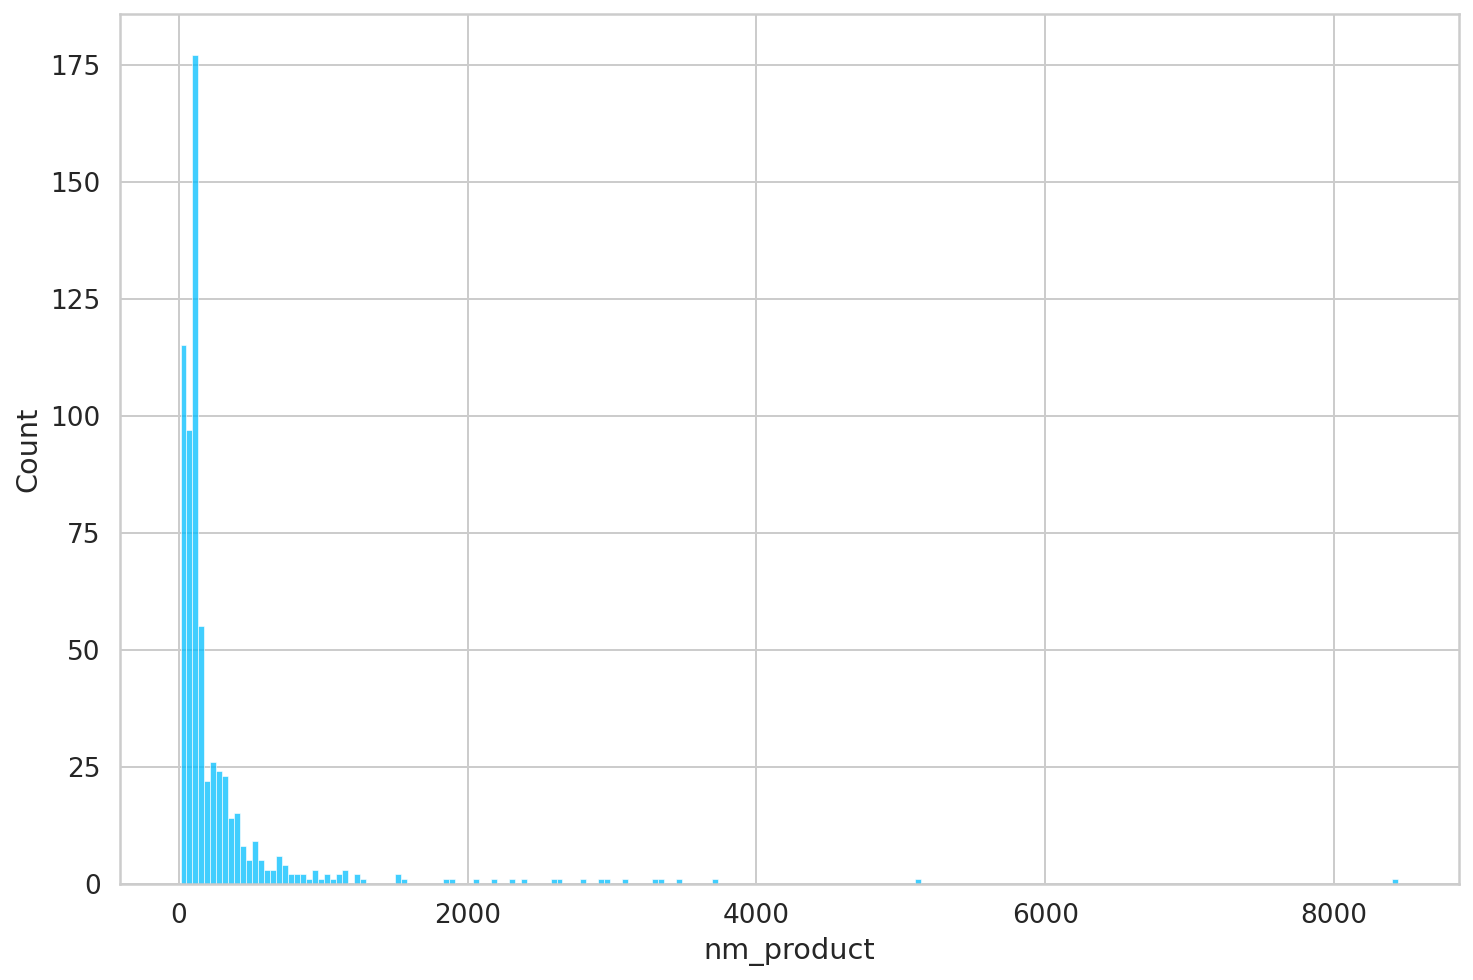

In [ ]:
sns.histplot(df['nm_product'].value_counts())

In [ ]:
df['nm_product'].value_counts().describe()

count     654.000000
mean      280.720183
std       592.053578
min        11.000000
25%        78.000000
50%       120.000000
75%       257.750000
max      8444.000000
Name: nm_product, dtype: float64

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((144078, 9), (24013, 9), (24013, 9))

In [ ]:
import nltk
nltk.download('stopwords')

def augment_text(df,class_threshold = 20):

    new_text=[]

    class_counts = df['nm_product'].value_counts()

    count_class = class_counts[class_counts <= class_threshold].index

    lst_stopwords = nltk.corpus.stopwords.words('portuguese') 
    aug = naw.SynonymAug(aug_min=1, aug_max=5, lang='por', stopwords=lst_stopwords)

    aug_key = nac.KeyboardAug(aug_char_min = 1 , aug_char_max = 3, stopwords = lst_stopwords )

    df_m = df[df['nm_product'].isin(count_class)].reset_index(drop=True)
    
    ## data augmentation loop

    final = pd.DataFrame()
    for i in range(0,len(df_m)):
            z=0
            text = df_m.iloc[i]['nm_item']
            augmented_text = aug.augment(text,n = 10)
            
            augmented_text = list(set(augmented_text))

            for text2 in augmented_text:

                augmented_text2 = aug_key.augment(text2,n = 5)

                augmented_text2 = list(set(augmented_text2))

                if i%100 == 0:

                    print(len(augmented_text))
                    print(len(augmented_text2))
                    print(i)

                base = pd.DataFrame(data = augmented_text2,columns = ['nm_item'] )

                base[['segmento','categoria','subcategoria','nm_product',
                    'segmento_enc','categoria_enc','subcategoria_enc','nm_product_enc']] = df_m.iloc[i][['segmento','categoria','subcategoria','nm_product',
                                                                                                        'segmento_enc','categoria_enc','subcategoria_enc','nm_product_enc']]

                df = pd.concat([df,base],ignore_index=True)

    ## dataframe

    df = df.drop_duplicates('nm_item').reset_index(drop=True)

    df = df.sample(frac = 1).reset_index(drop=True)

    return df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df_train2 = augment_text(df_train)

print(df_train.duplicated('nm_item').sum())

In [ ]:
df_train2.to_csv(os.path.join(filesave,"train_dataset2.csv"),sep=';',decimal=',',encoding='utf-8',
                    index=False)

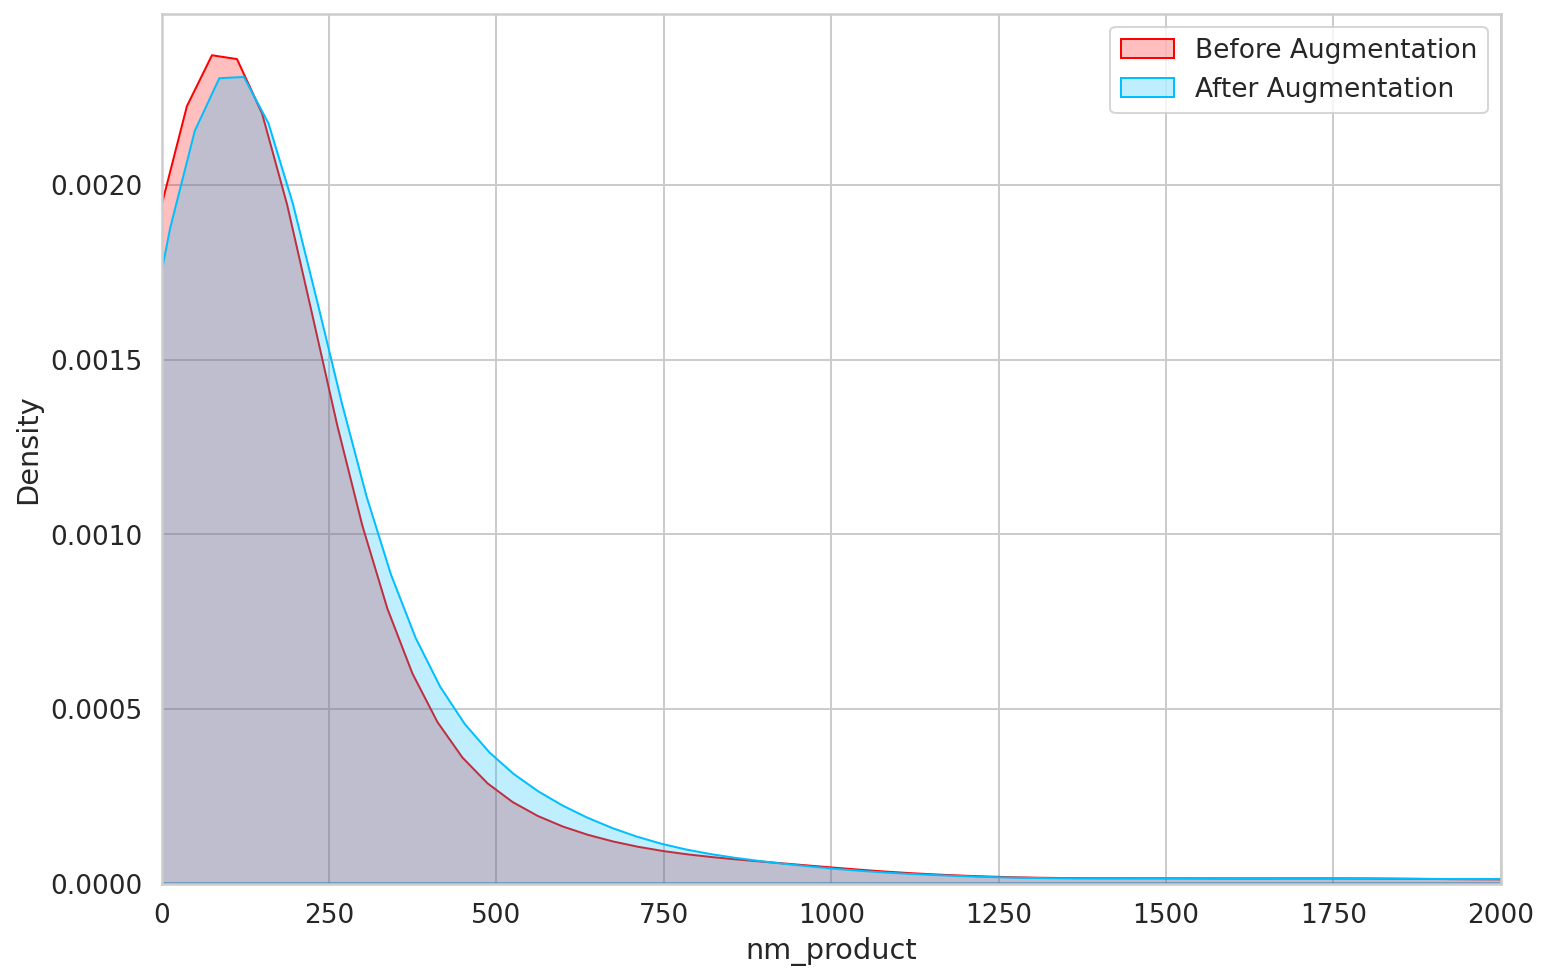

In [ ]:
sns.kdeplot(df_train['nm_product'].value_counts(),color = 'red',fill=True)
sns.kdeplot(df_train2['nm_product'].value_counts(),fill=True)
plt.xlim(0,2000)
plt.legend(['Before Augmentation','After Augmentation'])


In [ ]:
df_train2.shape, df_val.shape, df_test.shape

((158417, 9), (24013, 9), (24013, 9))

In [ ]:
df_train2.isnull().sum()

nm_item             0
segmento            0
categoria           0
subcategoria        0
nm_product          0
segmento_enc        0
categoria_enc       0
subcategoria_enc    0
nm_product_enc      0
dtype: int64

Também precisamos criar alguns load dos dados. Aqui está uma função auxiliar para fazer isso:

In [ ]:
def create_data_loader(X,y, tokenizer, max_len, batch_size):
  ds = ProdutosVarejoDataset(
    nm_item = X,
    targets = y.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

## Classificação de Produtos com  BERT

In [ ]:
class ProductClassifier(nn.Module):

  def __init__(self, number_classes,list_drop_out):

    super(ProductClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)

    self.drop = nn.Dropout(p= list_drop_out)

    # O last_hidden_state é uma sequência de estados ocultos da última camada do modelo
    self.out1 = nn.Linear(self.bert.config.hidden_size, number_classes[0])
    self.out2 = nn.Linear(self.bert.config.hidden_size, number_classes[1])
    self.out3 = nn.Linear(self.bert.config.hidden_size, number_classes[2])
    self.out4 = nn.Linear(self.bert.config.hidden_size, number_classes[3])
  
  def forward(self, input_ids, attention_mask):

    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)

    return [self.out1(output),self.out2(output),self.out3(output),self.out4(output)]

### Training

To reproduce the training procedure from the BERT paper, we'll use the [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw) optimizer provided by Hugging Face. It corrects weight decay, so it's similar to the original paper. We'll also use a linear scheduler with no warmup steps:

How do we come up with all hyperparameters? The BERT authors have some recommendations for fine-tuning:

- Batch size: 16, 32
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4

We're going to ignore the number of epochs recommendation but stick with the rest. Note that increasing the batch size reduces the training time significantly, but gives you lower accuracy.

Let's continue with writing a helper function for training our model for one epoch:

In [ ]:
class FocalLoss(nn.Module):
    "Focal loss implemented using F.cross_entropy"
    def __init__(self, gamma: float = 2.0, weight=None, reduction: str = 'sum') -> None:
        super().__init__()
        self.gamma = gamma
        self.weight = weight
        self.reduction = reduction


    def forward(self, inp: torch.Tensor, targ: torch.Tensor):
        ce_loss = F.cross_entropy(inp, targ, weight=self.weight, reduction="none")
        p_t = torch.exp(-ce_loss)
        loss = (1 - p_t)**self.gamma * ce_loss
        if self.reduction == "mean":
            loss = loss.mean()
        elif self.reduction == "sum":
            loss = loss.sum()
        return loss


In [ ]:
def train_epoch(
                model, 
                data_loader, 
                loss_fn, 
                optimizer, 
                device, 
                scheduler, 
                epoch
              ):

  model = model.train()

  losses = []
  correct_predictions = 0


  targets_total = []

  with tqdm(data_loader, unit="batch") as tepoch:

    for i,d in enumerate(tepoch):
      
      tepoch.set_description(f"Epoch {epoch}")

      input_ids_ = d["input_ids"].to(device)
      attention_mask_ = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      optimizer.zero_grad()

      outputs = model(
        input_ids=input_ids_,
        attention_mask=attention_mask_
      )

      loss1 = loss_fn[0](outputs[0], targets[:,0])
      loss2 = loss_fn[1](outputs[1], targets[:,1])
      loss3 = loss_fn[2](outputs[2], targets[:,2])
      loss4 = loss_fn[3](outputs[3], targets[:,3])

      loss = loss1 + loss2 + loss3 + loss4

      losses.append(loss.item())

      loss.backward()
      nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
      optimizer.step()
      scheduler.step()


      tepoch.set_postfix(loss=loss.item(),                     
                         )
  return  np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device):

  model = model.eval()

  losses = []

  final_preds1 = []
  final_preds2 = []
  final_preds3 = []
  final_preds4 = []

  targets_total = []


#   final_preds = [[],[],[],[]]

  i = 0 
  with torch.no_grad():

    for d in data_loader:

      input_ids_ = d["input_ids"].to(device)
      attention_mask_ = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      optimizer.zero_grad()

      outputs = model(
        input_ids=input_ids_,
        attention_mask=attention_mask_
      )

      loss1 = loss_fn[0](outputs[0], targets[:,0])
      loss2 = loss_fn[1](outputs[1], targets[:,1])
      loss3 = loss_fn[2](outputs[2], targets[:,2])
      loss4 = loss_fn[3](outputs[3], targets[:,3])

      loss = loss1 + loss2 + loss3 + loss4

      losses.append(loss.item())

      probs = list(map(lambda x : F.softmax(x, dim=1),outputs))

      final_preds1.extend(probs[0])
      final_preds2.extend(probs[1])
      final_preds3.extend(probs[2])
      final_preds4.extend(probs[3])
      targets_total.extend(targets)


  final_preds1 = torch.stack(final_preds1).cpu()
  final_preds2 = torch.stack(final_preds2).cpu()
  final_preds3 = torch.stack(final_preds3).cpu()
  final_preds4 = torch.stack(final_preds4).cpu()

  final_preds = [final_preds1,final_preds2,final_preds3,final_preds4]

  targets_total = torch.stack(targets_total).cpu()

  metrics = {}

  for i in range(4):

      _, best_values =  torch.max(final_preds[i],dim=1)

      metrics.update({'F1_SCORE_'+str(i):f1_score(targets_total[:,i].flatten(), best_values.detach(), average='macro')})

  return metrics

In [ ]:
%%time

model_dict={
            'base':{"batch_size":[32],
                           "lr_rate":[5e-5],
                           "gamma1":[0,0.5,1],
                            "gamma2":[1,0.5],
                            "gamma3":[1],
                            "gamma4":[2],
                            "drop_out":[0.5],
                           
                           },
                            }

EPOCHS = 30
EARLY_STOP = 5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


final_results = pd.read_csv(os.path.join(filesave,"BERT_PARAMETERS_v4.csv"),sep=';',decimal=',',encoding='utf-8')

# final_results = pd.DataFrame()

for modelo in model_dict.keys():
    
    for p in itertools.product(*model_dict[modelo].values()):
        z=0
        parameters=dict(zip(model_dict[modelo].keys(),p))

        if final_results.empty == False:

            check_results = final_results[final_results['Model']==modelo].reset_index(drop=True)

            if check_results.empty == False:   

                if str(parameters) in check_results['parameters'].to_list() :
                    
                    print('rodou')
                    continue

        history = defaultdict(list)
        best_accuracy = {'AUC':0.0,
                         'F1_SCORE':0.0}

        best_accuracy_val = 0 

        count = 0
        class_size = [df['segmento_enc'].nunique(),df['categoria_enc'].nunique(),df['subcategoria_enc'].nunique(),df['nm_product_enc'].nunique()]

        BATCH_SIZE = parameters['batch_size']

        train_data_loader = create_data_loader(df_train2['nm_item'],df_train2[['segmento_enc','categoria_enc','subcategoria_enc','nm_product_enc']], tokenizer, MAX_LEN, BATCH_SIZE)
        val_data_loader = create_data_loader(df_val['nm_item'],df_val[['segmento_enc','categoria_enc','subcategoria_enc','nm_product_enc']], tokenizer, MAX_LEN, BATCH_SIZE)
        test_data_loader = create_data_loader(df_test['nm_item'],df_test[['segmento_enc','categoria_enc','subcategoria_enc','nm_product_enc']], tokenizer, MAX_LEN, BATCH_SIZE)
        

        model = ProductClassifier(class_size,parameters['drop_out']).to(device)

        optimizer = AdamW(model.parameters(), lr= parameters['lr_rate'], correct_bias=False)
        total_steps = len(train_data_loader) * EPOCHS

        scheduler = get_cosine_with_hard_restarts_schedule_with_warmup(
        optimizer,
        num_warmup_steps= int(total_steps*0.05),
        num_training_steps=total_steps,
        num_cycles = 2

        )

        loss_fn = [FocalLoss(gamma = parameters['gamma1']).to(device),FocalLoss(gamma = parameters['gamma2']).to(device),FocalLoss(gamma = parameters['gamma3']).to(device),FocalLoss(gamma = parameters['gamma4']).to(device)]

        model = model.to(device)

        for epoch in range(EPOCHS):

            print(f'Epoch {epoch + 1}/{EPOCHS}')
            print('-' * 10)

            train_loss = train_epoch(
                model,
                train_data_loader, 
                loss_fn,
                optimizer, 
                device,
                scheduler,
                epoch = epoch
            )

            print(f'Train loss {train_loss}')

            metrics_val = eval_model(
                model,
                val_data_loader,
                loss_fn, 
                device,
            )

        
            F1_mean = (metrics_val['F1_SCORE_0']+metrics_val['F1_SCORE_1']+metrics_val['F1_SCORE_2']+metrics_val['F1_SCORE_3'])/4

            print('f1-score {f1_score}'.format(f1_score =F1_mean))

            if round(F1_mean,5) > round(best_accuracy_val,5):

                torch.save(model.state_dict(), 'best_model_state.bin')
                best_accuracy_val = F1_mean
                best_accuracy = metrics_val

                count = 0

            else:

                count += 1

                if count >= EARLY_STOP:

                    break

        metrics  =  eval_model(
                              model,
                              test_data_loader,
                              loss_fn, 
                              device,
                                    )

        results=pd.DataFrame([{'Model':modelo,
                    'parameters':parameters,

                    # 'AUC_VAL_SEGMENTO':best_accuracy['AUC_0'],
                    # 'AUC_VAL_CATEGORIA':best_accuracy['AUC_1'],
                    # 'AUC_VAL_SUBCATEGORIA':best_accuracy['AUC_2'],
                    # 'AUC_VAL_PRODUTO':best_accuracy['AUC_3'],

                    'F1_SCORE_VAL_SEGMENTO':best_accuracy['F1_SCORE_0'],
                    'F1_SCORE_VAL_CATEGORIA':best_accuracy['F1_SCORE_1'],
                    'F1_SCORE_VAL_SUBCATEGORIA':best_accuracy['F1_SCORE_2'],
                    'F1_SCORE_VAL_PRODUTO':best_accuracy['F1_SCORE_3'],

                    # 'AUC_TEST_SEGMENTO':metrics['AUC_0'],
                    # 'AUC_TEST_CATEGORIA':metrics['AUC_1'],
                    # 'AUC_TEST_SUBCATEGORIA':metrics['AUC_2'],
                    # 'AUC_TEST_PRODUTO':metrics['AUC_3'],

                    'F1_SCORE_TEST_SEGMENTO':metrics['F1_SCORE_0'],
                    'F1_SCORE_TEST_CATEGORIA':metrics['F1_SCORE_1'],
                    'F1_SCORE_TEST_SUBCATEGORIA':metrics['F1_SCORE_2'],
                    'F1_SCORE_TEST_PRODUTO':metrics['F1_SCORE_3'],

                    }])

        final_results=final_results.append(results,ignore_index=True)

        final_results.to_csv(os.path.join(filesave,"BERT_PARAMETERS_v4.csv"),sep=';',decimal=',',encoding='utf-8',
                    index=False)

In [ ]:
df_train_final = pd.concat([df_train2,df_val],ignore_index=True)

In [ ]:
%%time

model_dict={
            'base':{"batch_size":[32],
                           "lr_rate":[5e-5],
                           "gamma1":[2],
                            "gamma2":[1],
                            "gamma3":[1],
                            "gamma4":[2],
                            "drop_out":[0.5],
                           
                           },
                            }

EPOCHS = 40
EARLY_STOP = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# final_results = pd.read_csv(os.path.join(filesave,"BERT_PARAMETERS_v4.csv"),sep=';',decimal=',',encoding='utf-8')

final_results = pd.DataFrame()

for modelo in model_dict.keys():
    
    for p in itertools.product(*model_dict[modelo].values()):
        z=0
        parameters=dict(zip(model_dict[modelo].keys(),p))

        if final_results.empty == False:

            check_results = final_results[final_results['Model']==modelo].reset_index(drop=True)

            if check_results.empty == False:   

                if str(parameters) in check_results['parameters'].to_list() :
                    
                    print('rodou')
                    continue

        history = defaultdict(list)
        best_accuracy = {'AUC':0.0,
                         'F1_SCORE':0.0}

        best_accuracy_val = 0 

        count = 0
        class_size = [df['segmento_enc'].nunique(),df['categoria_enc'].nunique(),df['subcategoria_enc'].nunique(),df['nm_product_enc'].nunique()]

        BATCH_SIZE = parameters['batch_size']

        train_data_loader = create_data_loader(df_train_final[['nm_item']],df_train_final[['segmento_enc','categoria_enc','subcategoria_enc','nm_product_enc']], tokenizer, MAX_LEN, BATCH_SIZE)
        # val_data_loader = create_data_loader(df_val['nm_item'],df_val[['segmento_enc','categoria_enc','subcategoria_enc','nm_product_enc']], tokenizer, MAX_LEN, BATCH_SIZE)
        test_data_loader = create_data_loader(df_test[['nm_item']],df_test[['segmento_enc','categoria_enc','subcategoria_enc','nm_product_enc']], tokenizer, MAX_LEN, BATCH_SIZE)
        
        model = ProductClassifier(class_size,parameters['drop_out']).to(device)

        optimizer = AdamW(model.parameters(), lr= parameters['lr_rate'], correct_bias=False)
        total_steps = len(train_data_loader) * EPOCHS

        scheduler = get_cosine_with_hard_restarts_schedule_with_warmup(
        optimizer,
        num_warmup_steps= int(total_steps*0.05),
        num_training_steps=total_steps,
        num_cycles = 2

        )

        loss_fn = [FocalLoss(gamma = parameters['gamma1']).to(device),FocalLoss(gamma = parameters['gamma2']).to(device),FocalLoss(gamma = parameters['gamma3']).to(device),FocalLoss(gamma = parameters['gamma4']).to(device)]

        model = model.to(device)

        for epoch in range(EPOCHS):

            print(f'Epoch {epoch + 1}/{EPOCHS}')
            print('-' * 10)

            train_loss = train_epoch(
                model,
                train_data_loader, 
                loss_fn,
                optimizer, 
                device,
                scheduler,
                epoch = epoch
            )

            print(f'Train loss {train_loss}')

            metrics_val = eval_model(
                model,
                test_data_loader,
                loss_fn, 
                device,
            )

        
            F1_mean = (metrics_val['F1_SCORE_0']+metrics_val['F1_SCORE_1']+metrics_val['F1_SCORE_2']+metrics_val['F1_SCORE_3'])/4

            print('f1-score {f1_score}'.format(f1_score = F1_mean))

            if round(F1_mean,5) > round(best_accuracy_val,5):

                torch.save(model, os.path.join(filesave,'BERT_FINAL_MODELO.pth'))
                best_accuracy_val = F1_mean
                best_accuracy = metrics_val

                metrics  =  eval_model(
                              model,
                              test_data_loader,
                              loss_fn, 
                              device,
                                    )

                count = 0

            else:

                count += 1

                if count >= EARLY_STOP:

                    break

        results=pd.DataFrame([{'Model':modelo,
                    'parameters':parameters,

                    # 'AUC_VAL_SEGMENTO':best_accuracy['AUC_0'],
                    # 'AUC_VAL_CATEGORIA':best_accuracy['AUC_1'],
                    # 'AUC_VAL_SUBCATEGORIA':best_accuracy['AUC_2'],
                    # 'AUC_VAL_PRODUTO':best_accuracy['AUC_3'],

                    'F1_SCORE_VAL_SEGMENTO':best_accuracy['F1_SCORE_0'],
                    'F1_SCORE_VAL_CATEGORIA':best_accuracy['F1_SCORE_1'],
                    'F1_SCORE_VAL_SUBCATEGORIA':best_accuracy['F1_SCORE_2'],
                    'F1_SCORE_VAL_PRODUTO':best_accuracy['F1_SCORE_3'],

                    # 'AUC_TEST_SEGMENTO':metrics['AUC_0'],
                    # 'AUC_TEST_CATEGORIA':metrics['AUC_1'],
                    # 'AUC_TEST_SUBCATEGORIA':metrics['AUC_2'],
                    # 'AUC_TEST_PRODUTO':metrics['AUC_3'],

                    'F1_SCORE_TEST_SEGMENTO':metrics['F1_SCORE_0'],
                    'F1_SCORE_TEST_CATEGORIA':metrics['F1_SCORE_1'],
                    'F1_SCORE_TEST_SUBCATEGORIA':metrics['F1_SCORE_2'],
                    'F1_SCORE_TEST_PRODUTO':metrics['F1_SCORE_3'],

                    }])

        final_results=final_results.append(results,ignore_index=True)

        final_results.to_csv(os.path.join(filesave,"BERT_PARAMETERS_v5.csv"),sep=';',decimal=',',encoding='utf-8',
                    index=False)

### FUNCAO PARA ESCORGEM

Função para utilização do modelo

Vamos definir uma função auxiliar para obter as previsões do nosso modelo:

In [ ]:
### Instalar pacotes ###
!git clone https://github.com/MECAI2022/short_text_classification.git
!pip install transformers
#######

Cloning into 'short_text_classification'...
remote: Enumerating objects: 116, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 116 (delta 0), reused 0 (delta 0), pack-reused 112
Receiving objects: 100% (116/116), 3.30 MiB | 4.58 MiB/s, done.
Resolving deltas: 100% (62/62), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 20.9 MB/s 
     |████████████████████████████████| 182 kB 77.9 MB/s 
     |████████████████████████████████| 7.6 MB 45.4 MB/s 


In [ ]:
# Importar pacotes

import sys
sys.path.append('/content/short_text_classification')
from pre_treatment_product import pre_process_text
import os
import numpy as np
import pandas as pd
from sklearn import preprocessing
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from transformers import  BertTokenizer
import pickle
import torch


#Varivaveis globais
filesave = '/content/drive/MyDrive/BERT'

pre_treatment = pre_process_text(stopwords_language = 'portuguese',flg_stemm = True , flg_lemm = False)

PRE_TRAINED_MODEL_NAME = 'neuralmind/bert-base-portuguese-cased'

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


max_lenght = 38

encoders = {'segmento':pickle.load(open(os.path.join(filesave,'segmento_label_enc.dat'),'rb')),
            'categoria':pickle.load(open(os.path.join(filesave,'categoria_label_enc.dat'),'rb')),
            'subcategoria':pickle.load(open(os.path.join(filesave,'subcategoria_label_enc.dat'),'rb')),
            'nm_product':pickle.load(open(os.path.join(filesave,'nm_product_label_enc.dat'),'rb'))}


### Funcoes auxiliares ####
class ProdutosVarejoDataset(Dataset):

  def __init__(self, nm_item, tokenizer, max_len):
    self.nm_item = nm_item
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.nm_item)
  
  def __getitem__(self, item):
    
    nm_item = self.nm_item.iloc[item,0]

    nm_item2 = pre_treatment.transform(nm_item)

    encoding = self.tokenizer.encode_plus(
      nm_item2,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'nm_item_text': nm_item,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
    }

def create_data_loader(X,tokenizer, max_len, batch_size=64):
  ds = ProdutosVarejoDataset(
    nm_item = X,
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

class ProductClassifier(nn.Module):

  def __init__(self, number_classes,list_drop_out):

    super(ProductClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)

    self.drop = nn.Dropout(p= list_drop_out)

    # O last_hidden_state é uma sequência de estados ocultos da última camada do modelo
    self.out1 = nn.Linear(self.bert.config.hidden_size, number_classes[0])
    self.out2 = nn.Linear(self.bert.config.hidden_size, number_classes[1])
    self.out3 = nn.Linear(self.bert.config.hidden_size, number_classes[2])
    self.out4 = nn.Linear(self.bert.config.hidden_size, number_classes[3])
  
  def forward(self, input_ids, attention_mask):

    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)

    return [self.out1(output),self.out2(output),self.out3(output),self.out4(output)]
######




## Pipeline escoragem modelo 
def pipeline (text,topk = None):

    if isinstance(text, str):

        text2 =  pre_treatment.transform(text)

    else:

        test_data_loader = create_data_loader(text, tokenizer, max_lenght)

    model = torch.load(os.path.join(filesave,'BERT_FINAL_MODELO.pth'))
    model = model.to(device).eval() 

    table_final = pd.DataFrame()
    with torch.no_grad():

        if isinstance(text, str):

            encoded_review = tokenizer.encode_plus(
                        text2,
                        max_length=max_lenght,
                        add_special_tokens=True,
                        return_token_type_ids=False,
                        padding='max_length',
                        truncation=True,
                        return_attention_mask=True,
                        return_tensors='pt',
                        )

            input_ids = encoded_review['input_ids'].to(device)
            attention_mask = encoded_review['attention_mask'].to(device)

            output = model(input_ids, attention_mask)

            probs = list(map(lambda x : F.softmax(x, dim=1),output))

            table_final = pd.DataFrame()

            if not topk:

                topk = 5

            topk_cols = ['Top '+str(x) for x in range(1,topk+1)]

            for i,name in enumerate(['segmento','categoria','subcategoria','nm_product']):

                _, prediction = torch.topk(probs[i], topk)
                index = prediction.cpu().data.numpy().flatten()

                top_group = encoders[name].inverse_transform(index)

                apoio = pd.DataFrame(index=topk_cols,columns = [name],
                                    data = top_group)
                
                table_final = pd.concat([table_final,apoio],axis=1)

            
        else:
            
            final_preds1 = []
            final_preds2 = []
            final_preds3 = []
            final_preds4 = []
            nm_item_text_final = []


            for d in test_data_loader:
                
                print(len(d))
                nm_item_text = d['nm_item_text']
                input_ids_ = d["input_ids"].to(device)
                attention_mask_ = d["attention_mask"].to(device)

                output = model(input_ids_, attention_mask_)

                probs = list(map(lambda x : F.softmax(x, dim=1),output))

                nm_item_text_final.extend(nm_item_text)
                final_preds1.extend(probs[0])
                final_preds2.extend(probs[1])
                final_preds3.extend(probs[2])
                final_preds4.extend(probs[3])

            final_preds1 = torch.stack(final_preds1).cpu()
            final_preds2 = torch.stack(final_preds2).cpu()
            final_preds3 = torch.stack(final_preds3).cpu()
            final_preds4 = torch.stack(final_preds4).cpu()

            final_preds = [final_preds1,final_preds2,final_preds3,final_preds4]

            for i,name in enumerate(['segmento','categoria','subcategoria','nm_product']):

                best_values =  torch.max(final_preds[i],dim=1)[1].cpu()

                best_group = encoders[name].inverse_transform(best_values)

                apoio = pd.DataFrame(index=nm_item_text_final,columns = [name],
                                    data = best_group)
                
                table_final = pd.concat([table_final,apoio],axis=1)


        return table_final



In [ ]:
### Teste apenas ###
from google.colab import drive
drive.mount('/content/drive')

filepath = "/content/drive/MyDrive/glove_files/dataset_produtos_V02.xlsx"
filesave = '/content/drive/MyDrive/BERT'

df = pd.read_excel(filepath)
df.head()

Mounted at /content/drive


/usr/local/lib/python3.8/dist-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,nm_item,segmento,categoria,subcategoria,nm_product
0,CUECA SUNGA LUPO G817,4-FASHION E ESPORTIVO,66-VESTUARIO,165-MODA INTIMA,CUECA
1,TOUCA DE NATACAO GLIDE BESTWAY26006,4-FASHION E ESPORTIVO,63-VESTUARIO ESPORTIVO,156-ROUPAS AQUATICAS,TOUCA DE NATACAO
2,OCULOS NAT INFANT UND,4-FASHION E ESPORTIVO,61-ARTIGOS ESPORTIVOS,147-ARTIGOS DE PROTECAO,OCULOS DE NATACAO
3,ES SUNGA LISA MASC V22,4-FASHION E ESPORTIVO,66-VESTUARIO,167-MODA PRAIA,SUNGA
4,SUNGA FOLHAGEM TEX AZL 200121 MPPV21,4-FASHION E ESPORTIVO,66-VESTUARIO,167-MODA PRAIA,SUNGA


In [ ]:
text = 'Fermento'
topk = 1

#test = df[['nm_item']].iloc[:20]
test = 'PRESUNTO'

pipeline (test)

,segmento,categoria,subcategoria,nm_product
Top 1,BENS DE CONSUMO,FRIOS E LATICINIOS,EMBUTIDOS,PRESUNTO
Top 2,PETROQUIMICA,PREPARADOS E CONGELADOS,FIAMBRERIA E SALSICHARIA,OUTRO EMBUTIDO
Top 3,CASA E CONSTRUCAO,HORTIFRUTI FLV,LATICINIOS REFRIGERADOS,MORTADELA
Top 4,HEALTHCARE,ACOUGUE E PEIXARIA,VERDURAS,SALSICHA
Top 5,FASHION E ESPORTIVO,LACTEOS,FRUTAS,APRESUNTADO
